In [50]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib
from typing import Tuple

In [51]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_recall_curve, roc_curve, roc_auc_score, auc
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.preprocessing import StandardScaler

In [52]:
from pathlib import Path
from sklearn.calibration import calibration_curve, CalibratedClassifierCV
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.metrics import (
    average_precision_score,
    log_loss,
    precision_recall_fscore_support,
)
from sklearn.model_selection import GridSearchCV

# Upload Data and Analysis

### Exactly the same thing than module_3 so I will not stop to much in this part.

### Focuse will be but on the model fitting part, with non linear models

In [53]:
BASE_PATH = r"C:\Users\Alberto\Desktop\Zrive\zrive-ds\Data set_Modulo2"
download_path=f"{BASE_PATH}/feature_frame.csv"
df = pd.read_csv(download_path)

In [54]:
df.head()

,variant_id,product_type,order_id,user_id,created_at,order_date,user_order_seq,outcome,ordered_before,abandoned_before,...,count_children,count_babies,count_pets,people_ex_baby,days_since_purchase_variant_id,avg_days_to_buy_variant_id,std_days_to_buy_variant_id,days_since_purchase_product_type,avg_days_to_buy_product_type,std_days_to_buy_product_type
0,33826472919172,ricepastapulses,2807985930372,3482464092292,2020-10-05 16:46:19,2020-10-05 00:00:00,3,0.0,0.0,0.0,...,0.0,0.0,0.0,2.0,33.0,42.0,31.134053,30.0,30.0,24.27618
1,33826472919172,ricepastapulses,2808027644036,3466586718340,2020-10-05 17:59:51,2020-10-05 00:00:00,2,0.0,0.0,0.0,...,0.0,0.0,0.0,2.0,33.0,42.0,31.134053,30.0,30.0,24.27618
2,33826472919172,ricepastapulses,2808099078276,3481384026244,2020-10-05 20:08:53,2020-10-05 00:00:00,4,0.0,0.0,0.0,...,0.0,0.0,0.0,2.0,33.0,42.0,31.134053,30.0,30.0,24.27618
3,33826472919172,ricepastapulses,2808393957508,3291363377284,2020-10-06 08:57:59,2020-10-06 00:00:00,2,0.0,0.0,0.0,...,0.0,0.0,0.0,2.0,33.0,42.0,31.134053,30.0,30.0,24.27618
4,33826472919172,ricepastapulses,2808429314180,3537167515780,2020-10-06 10:37:05,2020-10-06 00:00:00,3,0.0,0.0,0.0,...,0.0,0.0,0.0,2.0,33.0,42.0,31.134053,30.0,30.0,24.27618


In [76]:
info_cols = ["variant_id", "order_id", "user_id", "created_at", "order_date"]
label_col = "outcome"
features_cols = [col for col in df.columns if col not in info_cols + [label_col]]

categorical_cols = ["product_type", "vendor"]
binary_cols = ["ordered_before", "abandoned_before", "active_snoozed", "set_as_regular"]
numerical_cols = [
    col for col in features_cols if col not in categorical_cols + binary_cols
]


In [77]:
def push_relevant_dataframe(df: pd.DataFrame, min_products: int = 5) -> pd.DataFrame:
    """Only interested in order that have more than 5 products"""
    order_size = df.groupby("order_id").outcome.sum()
    order_of_min_size = order_size[order_size>= min_products].index
    return df.loc[lambda x: x.order_id.isin(order_of_min_size)]

df_selected= (
    df.pipe(push_relevant_dataframe)
    .assign(created_at=lambda x: pd.to_datetime(x.created_at))
    .assign(order_date= lambda x: pd.to_datetime(x.order_date).dt.date)
)

In [78]:
df_selected.dtypes

variant_id                                   int64
product_type                                object
order_id                                     int64
user_id                                      int64
created_at                          datetime64[ns]
order_date                                  object
user_order_seq                               int64
outcome                                    float64
ordered_before                             float64
abandoned_before                           float64
active_snoozed                             float64
set_as_regular                             float64
normalised_price                           float64
discount_pct                               float64
vendor                                      object
global_popularity                          float64
count_adults                               float64
count_children                             float64
count_babies                               float64
count_pets                     

In [79]:
df.order_id.nunique() > df_selected.order_id.nunique()

True

Text(0.5, 1.0, 'Daily Orders')

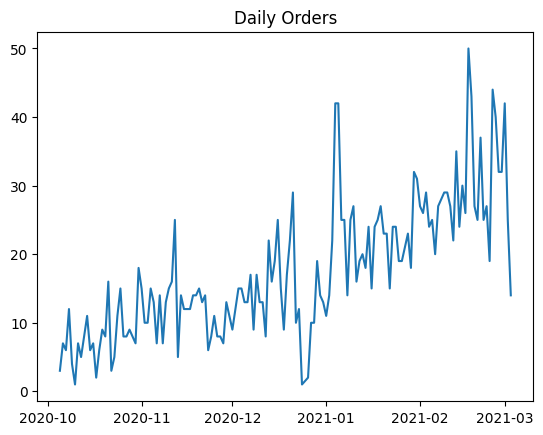

In [80]:
daily_orders = df_selected.groupby("order_date").order_id.nunique()
plt.plot(daily_orders, label = "daily orders")
plt.title("Daily Orders")

In [81]:
cumsum_daily_orders = daily_orders.cumsum() / daily_orders.sum()
cumsum_daily_orders

order_date
2020-10-05    0.001153
2020-10-06    0.003842
2020-10-07    0.006147
2020-10-08    0.010757
2020-10-09    0.012294
                ...   
2021-02-27    0.956589
2021-02-28    0.968882
2021-03-01    0.985017
2021-03-02    0.994622
2021-03-03    1.000000
Name: order_id, Length: 149, dtype: float64

In [82]:
train_val_cutoff = cumsum_daily_orders[cumsum_daily_orders <= 0.7].idxmax()
val_test_cutoff = cumsum_daily_orders[cumsum_daily_orders <= 0.9].idxmax()

print("Start:",cumsum_daily_orders.index.min())
print("End train:",train_val_cutoff)
print("End val:",val_test_cutoff)
print("End:",cumsum_daily_orders.index.max())

Start: 2020-10-05
End train: 2021-02-04
End val: 2021-02-22
End: 2021-03-03


In [83]:
train_df = df_selected[df_selected.order_date <= train_val_cutoff]
val_df = df_selected[
    (df_selected.order_date > train_val_cutoff)
    & (df_selected.order_date <= val_test_cutoff)
]
test_df = df_selected[df_selected.order_date > val_test_cutoff]

## Until here I have the dataset divided in train (70%), validation (20%) and test (10%)

Exactly the same as the last module

# Baseline

### For the baseline we use the Rigde regression of the module 3, with 1e-6 as C for regularisation

In [84]:
def plot_metrics(
        model_name: str,
        y_pred: pd.Series,
        y_test: pd.Series,
        target_precision: float = 0.05,
        figure: Tuple[matplotlib.figure.Figure, np.array] = None,
        
): 
        precision_, recall_, _ = precision_recall_curve(y_test, y_pred)
        pr_auc = auc(recall_, precision_)

        fpr, tpr, _ = roc_curve(y_test, y_pred)
        roc_auc = roc_auc_score(y_test, y_pred)

        if figure is None:
                fig, ax = plt.subplots(1, 2, figsize = (14,7))
        else:
                fig, ax = figure

        ax[0].plot(recall_, precision_, label= f"{model_name}; AUC: {pr_auc:2f}")
        ax[0].set_xlabel("recall")
        ax[0].set_ylabel("precision")
        ax[0].set_title(f"Precision-recall Curve")
        ax[0].legend()

        ax[1].plot(fpr,tpr, label=f"{model_name}; AUC: {roc_auc:.2f}")
        ax[1].set_xlabel("FPR")
        ax[1].set_ylabel("TPR")
        ax[1].set_title(f"ROC Curve")
        ax[1].legend()

In [85]:
def features_label_split(
        df: pd.DataFrame, label_col: str
) -> Tuple[pd.DataFrame, pd.Series]:
    return df.drop(label_col, axis=1), df[label_col]

X_train, y_train = features_label_split(train_df, label_col)
X_val, y_val = features_label_split(val_df, label_col)
X_test, y_test = features_label_split(test_df, label_col)

I am going to try to create a function to evaluate the configuration of the model so i can use it each time I train a model

Function to evaluate the metrics AUC, Precision recall y crossentropy

In [86]:
def evaluate_configuration(
    clf,
    X_train,
    y_train,
    X_val,
    y_val,
    train_aucs_list,
    val_aucs_list,
    train_ce_list,
    val_ce_list,
    train_aps_list,
    val_aps_list,
):
    val_preds = clf.predict_proba(X_val)[:, 1]
    train_preds = clf.predict_proba(X_train)[:, 1]
    train_auc = roc_auc_score(y_train, train_preds)
    val_auc = roc_auc_score(y_val, val_preds)

    train_crossentropy = log_loss(y_train, train_preds)
    val_crossentropy = log_loss(y_val, val_preds)

    train_ap = average_precision_score(y_train, train_preds)
    val_ap = average_precision_score(y_val, val_preds)

    train_aucs_list.append(train_auc)
    val_aucs_list.append(val_auc)
    train_ce_list.append(train_crossentropy)
    val_ce_list.append(val_crossentropy)
    train_aps_list.append(train_ap)
    val_aps_list.append(val_ap)


In [87]:
def plot_feature_importance(clf, columns):
    fig, ax = plt.subplots()
    fi = pd.DataFrame(
        list(zip(columns, clf.feature_importances_)), columns = ["features", "importance"]
    ).sort_values(by= "importance", ascending=True)
    fi.plot(kind = "barh",x = "features", y = "importance", ax = ax)
    return fi, fig, ax

In [88]:
columns = numerical_cols + binary_cols

In [89]:
lr_push_train_aucs =  []
lr_push_val_aucs =  []
lr_push_train_ce =  []
lr_push_val_ce =  []
lr_push_train_aps=  []
lr_push_val_aps =  []

lr = make_pipeline(
    StandardScaler(),
    LogisticRegression(penalty= "l2", C=1e-6),
)

lr.fit(X_train[columns], y_train)

evaluate_configuration(
    lr,
    X_train[columns],
    y_train,
    X_val[columns],
    y_val,
    lr_push_train_aucs,
    lr_push_val_aucs,
    lr_push_train_ce,
    lr_push_val_ce,
    lr_push_train_aps,
    lr_push_val_aps,
)


In [90]:
print(
    f"C: 1e-6 done with train auc: {lr_push_train_aucs[-1]:.4f} and val auc: {lr_push_val_aucs[-1]:.4f}. "
    f"AP train: {lr_push_train_aps[-1]:.4f} and val: {lr_push_val_aps[-1]:.4f}. "
    f"Cross entropy train: {lr_push_train_ce[-1]:.4f}, val: {lr_push_val_ce[-1]:.4f}."
)


C: 1e-6 done with train auc: 0.8254 and val auc: 0.8326. AP train: 0.1562 and val: 0.1603. Cross entropy train: 0.0762, val: 0.0694.


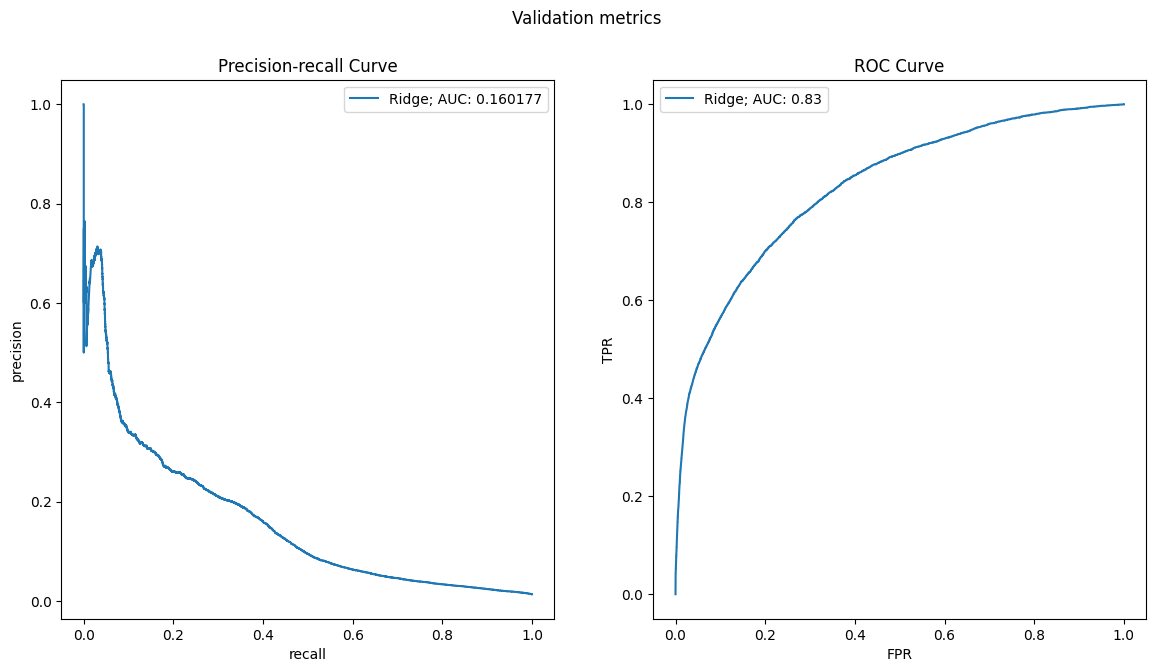

In [91]:
val_preds = lr.predict_proba(X_val[columns])[:, 1]

fig2, ax2 = plt.subplots(1, 2, figsize = (14, 7))
fig2.suptitle("Validation metrics")

plot_metrics(
    f"Ridge", y_pred=val_preds, y_test= val_df[label_col], figure = (fig2, ax2)
)

 Charts of Precision recall and AUC

# Model fitting ==> Non linear 

### Random Forest

In [92]:
n_trees_grid = [5, 25, 50, 100]

rf_push_train_aucs = []
rf_push_val_aucs = []

rf_push_train_ce = []
rf_push_val_ce = []

rf_push_train_aps = []
rf_push_val_aps = []

for n_trees in n_trees_grid:
    rf = RandomForestClassifier(n_trees)
    rf.fit(X_train[columns], y_train)


In [93]:
n_trees_grid = [5, 25, 50, 100]

rf_push_train_aucs = []
rf_push_val_aucs = []

rf_push_train_ce = []
rf_push_val_ce = []

rf_push_train_aps = []
rf_push_val_aps = []

for n_trees in n_trees_grid:
    rf = RandomForestClassifier(n_trees)
    rf.fit(X_train[columns], y_train)
    evaluate_configuration(
        rf,
        X_train[columns],
        y_train,
        X_val[columns],
        y_val,
        rf_push_train_aucs,
        rf_push_val_aucs,
        rf_push_train_ce,
        rf_push_val_ce,
        rf_push_train_aps,
        rf_push_val_aps,
    )
    print(
        f"# Trees: {n_trees} done with train auc: {rf_push_train_aucs[-1]:.4f} and val auc: {rf_push_val_aucs[-1]:.4f}. "
        f"AP train: {rf_push_train_aps[-1]:.4f} and val: {rf_push_val_aps[-1]:.4f}. "
        f"Cross entropy train: {rf_push_train_ce[-1]:.4f}, val: {rf_push_val_ce[-1]:.4f}"
)


# Trees: 5 done with train auc: 0.9904 and val auc: 0.6511. AP train: 0.7715 and val: 0.0749. Cross entropy train: 0.0247, val: 0.3401
# Trees: 25 done with train auc: 0.9952 and val auc: 0.7147. AP train: 0.8517 and val: 0.1135. Cross entropy train: 0.0209, val: 0.2486
# Trees: 50 done with train auc: 0.9955 and val auc: 0.7316. AP train: 0.8594 and val: 0.1193. Cross entropy train: 0.0208, val: 0.2196
# Trees: 100 done with train auc: 0.9957 and val auc: 0.7509. AP train: 0.8626 and val: 0.1255. Cross entropy train: 0.0207, val: 0.1863


Ramdon forest first observation, AUC in train is not 100% even if for random forest we are creating the trees until the end so it should be 100%. That means that we have lines with exactly the same value on the variables but at the end the output is different.

The random forest that seems to work better is the one with 100 trees.

In [94]:
rf = RandomForestClassifier(100)
rf.fit(X_train[columns], y_train)

RandomForestClassifier()

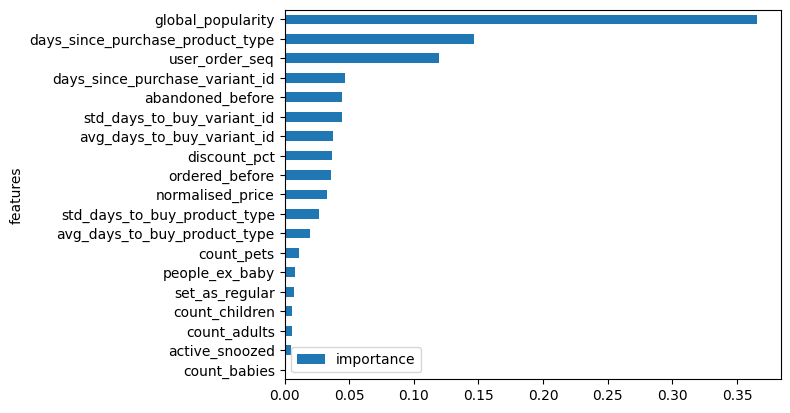

In [95]:
rf_fi, fig, ax = plot_feature_importance(rf, columns)

Deleting the lowest important variable ==> I keep only the first 15

In [96]:
filtered_columns = rf_fi["features"].iloc[:15]

In [97]:
n_trees_grid = [5, 25, 50, 100]

rf_push_train_aucs = []
rf_push_val_aucs = []

rf_push_train_ce = []
rf_push_val_ce = []

rf_push_train_aps = []
rf_push_val_aps = []

for n_trees in n_trees_grid:
    rf = RandomForestClassifier(n_trees)
    rf.fit(X_train[filtered_columns], y_train)
    evaluate_configuration(
        rf,
        X_train[filtered_columns],
        y_train,
        X_val[filtered_columns],
        y_val,
        rf_push_train_aucs,
        rf_push_val_aucs,
        rf_push_train_ce,
        rf_push_val_ce,
        rf_push_train_aps,
        rf_push_val_aps,
    )
    print(
        f"# Trees: {n_trees} done with train auc: {rf_push_train_aucs[-1]:.4f} and val auc: {rf_push_val_aucs[-1]:.4f}. "
        f"AP train: {rf_push_train_aps[-1]:.4f} and val: {rf_push_val_aps[-1]:.4f}. "
        f"Cross entropy train: {rf_push_train_ce[-1]:.4f}, val: {rf_push_val_ce[-1]:.4f}"
)

# Trees: 5 done with train auc: 0.8487 and val auc: 0.7664. AP train: 0.2503 and val: 0.1466. Cross entropy train: 0.0599, val: 0.1002
# Trees: 25 done with train auc: 0.8499 and val auc: 0.7882. AP train: 0.2576 and val: 0.1565. Cross entropy train: 0.0592, val: 0.0831
# Trees: 50 done with train auc: 0.8499 and val auc: 0.7925. AP train: 0.2584 and val: 0.1588. Cross entropy train: 0.0592, val: 0.0805
# Trees: 100 done with train auc: 0.8500 and val auc: 0.7930. AP train: 0.2588 and val: 0.1600. Cross entropy train: 0.0592, val: 0.0780


We achieve better AUC and precision recall than with all the variables. 

Conclusion: Reducing the columns increase the performance of our model. Therefore, we have worst perfomance than our Logistic regresion (linear model). Thank means that we will rather the linear model over this one

## Gradient boosting trees

In [98]:
n_trees_grid = [5, 25, 50, 100]

gbt_push_train_aucs = []
gbt_push_val_aucs = []

gbt_push_train_ce = []
gbt_push_val_ce = []

gbt_push_train_aps = []
gbt_push_val_aps = []

for lr in [0.05, 0.1]:
    for depth in [1, 3, 5]:
        for n_trees in n_trees_grid:
            gbt = GradientBoostingClassifier(
                learning_rate=lr, max_depth= depth, n_estimators= n_trees
            )
            gbt.fit(X_train[columns], y_train)

            evaluate_configuration(
                gbt,
                X_train[columns],
                y_train,
                X_val[columns],
                y_val,
                gbt_push_train_aucs,
                gbt_push_val_aucs,
                gbt_push_train_ce,
                gbt_push_val_ce,
                gbt_push_train_aps,
                gbt_push_val_aps,
            )
            print(
                f"LR: {lr} max depth: {depth} trees: {n_trees} done with"
                f"train auc: {gbt_push_train_aucs[-1]:.4f} and val auc: {gbt_push_val_aucs[-1]:.4f}. "
                f"AP train: {gbt_push_train_aps[-1]:.4f} and val: {gbt_push_val_aps[-1]:.4f}. "
                f"Cross entropy train: {gbt_push_train_ce[-1]:.4f}, val: {gbt_push_val_ce[-1]:.4f}"
            )


LR: 0.05 max depth: 1 trees: 5 done withtrain auc: 0.6461 and val auc: 0.6543. AP train: 0.0909 and val: 0.0763. Cross entropy train: 0.0729, val: 0.0670
LR: 0.05 max depth: 1 trees: 25 done withtrain auc: 0.7680 and val auc: 0.7544. AP train: 0.1332 and val: 0.1214. Cross entropy train: 0.0691, val: 0.0635
LR: 0.05 max depth: 1 trees: 50 done withtrain auc: 0.8163 and val auc: 0.8109. AP train: 0.1554 and val: 0.1418. Cross entropy train: 0.0662, val: 0.0609
LR: 0.05 max depth: 1 trees: 100 done withtrain auc: 0.8300 and val auc: 0.8313. AP train: 0.1680 and val: 0.1628. Cross entropy train: 0.0644, val: 0.0586
LR: 0.05 max depth: 3 trees: 5 done withtrain auc: 0.7793 and val auc: 0.7677. AP train: 0.1516 and val: 0.1350. Cross entropy train: 0.0701, val: 0.0647
LR: 0.05 max depth: 3 trees: 25 done withtrain auc: 0.8221 and val auc: 0.8233. AP train: 0.1810 and val: 0.1719. Cross entropy train: 0.0650, val: 0.0592
LR: 0.05 max depth: 3 trees: 50 done withtrain auc: 0.8359 and val auc:

In [99]:
lr_best = 0.05
max_depth_best = 5
n_estimators_best = 50

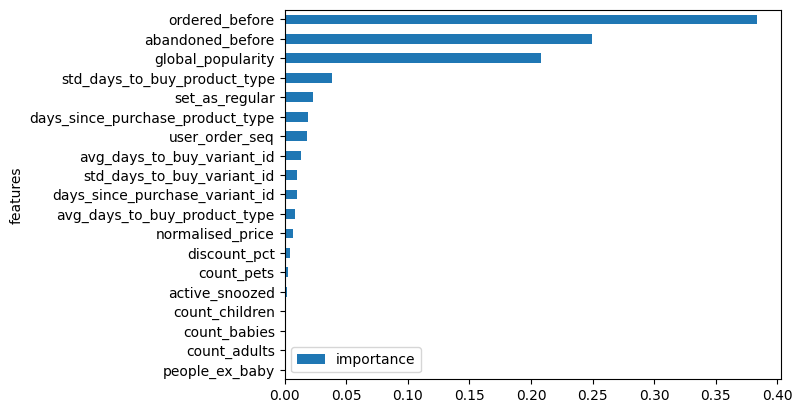

In [100]:
gbt = GradientBoostingClassifier(
    learning_rate = lr_best, max_depth= max_depth_best, n_estimators=n_estimators_best
)

gbt.fit(X_train[columns], y_train)
gbt_fi, fig, ax = plot_feature_importance(gbt, columns)

In [104]:
gbt_colums = (
    gbt_fi.loc[gbt_fi["importance"] > 0]
    .sort_values(by="importance", ascending = False)["features"]
    .tolist()
)

gbt_colums = gbt_colums[:15]

In [106]:
gbt_push_train_aucs = []
gbt_push_val_aucs = []

gbt_push_train_ce = []
gbt_push_val_ce = []

gbt_push_train_aps = []
gbt_push_val_aps = []

gbt = GradientBoostingClassifier(
    learning_rate = lr_best, max_depth= max_depth_best, n_estimators=n_estimators_best
)

gbt.fit(X_train[gbt_colums], y_train)

evaluate_configuration(
    gbt,
    X_train[gbt_colums],
    y_train,
    X_val[gbt_colums],
    y_val,
    gbt_push_train_aucs,
    gbt_push_val_aucs,
    gbt_push_train_ce,
    gbt_push_val_ce,
    gbt_push_train_aps,
    gbt_push_val_aps,

)
print(
    f"LR: {lr_best} max depth: {max_depth_best} trees: {n_estimators_best} done with"
    f"train auc: {gbt_push_train_aucs[-1]:.4f} and val auc: {gbt_push_val_aucs[-1]:.4f}. "
    f"AP train: {gbt_push_train_aps[-1]:.4f} and val: {gbt_push_val_aps[-1]:.4f}. "
    f"Cross entropy train: {gbt_push_train_ce[-1]:.4f}, val: {gbt_push_val_ce[-1]:.4f}"
)

LR: 0.05 max depth: 5 trees: 50 done withtrain auc: 0.8402 and val auc: 0.8442. AP train: 0.2094 and val: 0.1927. Cross entropy train: 0.0619, val: 0.0563


# Conclusions

### The last Gradient tree boost was the best performing model, with a validation AUC of 0.8442 and precision recall of 0.1927.

### This will be the model selected since it also outperform the Logistic regresion used as baseline